# 1. Estimate counts of agricultural & urban laborers, smallholders, and other via MapSPAM and GPW data. 

In [50]:
import rasterio
import numpy as np
import glob
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds, Window
import os
from tqdm.notebook import tqdm # Use tqdm.notebook if in Jupyter, otherwise just tqdm
import warnings # To control warnings

# --- Configuration ---
gpw_file = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\gpw_africa_data\gpwv4_popdensity_2020.tiff" # Ensure this path is correct
spam_folder = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\AgriculturalProduction\Global_Geotiff\spam2020V1r0_global_harvested_area-geotiff" # Ensure this path is correct

# Approximate Lat/Lon bounds for Sub-Saharan Africa (adjust if needed)
ssa_bounds = {
    'left': -20.0,
    'bottom': -35.0,
    'right': 55.0,
    'top': 20.0
}

# Population density threshold for urban classification (persons per square km)
# !!! IMPORTANT: User specified 30000, but noted it might be high. Using 30000. Verify!
urban_density_threshold = 500 # PLEASE VERIFY THIS THRESHOLD

# Indices for the attribution dimension
URBAN_IDX = 0
AG_LABORER_IDX = 1
SMALLHOLDER_IDX = 2

# Define Non-Food Crop Codes (uppercase as per SPAM file naming convention)
NON_FOOD_CROPS = {
    "OILP", "SUNF", "RAPE", "SESA", "OOIL", "SUGC", "SUGB",
    "COTT", "OFIB", "ACOF", "RCOF", "COCO", "TEAS", "TOBA", "REST"
}

# Earth radius in kilometers (use a mean radius)
EARTH_RADIUS_KM = 6371.0

# --- Helper Function: Get SPAM Metadata ---
# (Assumes the corrected version from previous steps is used)
def get_target_spam_metadata(spam_files):
    """Reads the first SPAM file to get target grid metadata."""
    if not spam_files:
        raise FileNotFoundError("No SPAM files found matching the pattern.")

    with rasterio.open(spam_files[0]) as src:
        profile = src.profile
        transform = profile.get('transform', src.transform)
        crs = profile.get('crs', src.crs)
        dtype = profile.get('dtype', src.dtypes[0])
        width = profile.get('width', src.width)
        height = profile.get('height', src.height)

        metadata = {
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height,
            'bounds': src.bounds,
            'dtype': dtype
        }
    print(f"Target SPAM grid: CRS={metadata['crs']}, Shape=({metadata['height']}, {metadata['width']}), Dtype={metadata['dtype']}")
    print(f"Target SPAM Transform: {metadata['transform']}")
    return metadata

# --- Helper Function: Calculate Pixel Area Raster (km²) ---
def get_pixel_area_raster_km2(transform, shape, crs):
    """
    Calculates the approximate area of each pixel in km² for a grid
    in a geographic CRS (like EPSG:4326).
    """
    if not crs or not crs.is_geographic:
        raise ValueError("CRS must be geographic to calculate area based on lat/lon.")

    pixel_height_deg = abs(transform.e) # Pixel height in degrees
    pixel_width_deg = abs(transform.a)  # Pixel width in degrees
    rows, cols = shape
    row_indices = np.arange(rows)
    latitudes_deg = transform.f + (row_indices + 0.5) * transform.e
    latitudes_rad = np.radians(latitudes_deg)
    deg2rad = np.pi / 180.0
    area_per_pixel_row_km2 = (
        (pixel_width_deg * deg2rad * EARTH_RADIUS_KM) *
        (pixel_height_deg * deg2rad * EARTH_RADIUS_KM * np.cos(latitudes_rad))
    )
    pixel_area_grid_km2 = np.tile(area_per_pixel_row_km2, (cols, 1)).T
    return pixel_area_grid_km2.astype(np.float32)


# --- Step 1: Load GPW, Subset SSA, Align to SPAM Grid ---
print("Step 1: Processing GPW Population Density Data...")
spam_h_files = glob.glob(os.path.join(spam_folder, "spam2020_v1r0_global_H_*_*.tif"))
if not spam_h_files: raise FileNotFoundError(f"No SPAM HA files found in {spam_folder}")

target_meta = get_target_spam_metadata(spam_h_files)
target_crs = target_meta['crs']; target_transform = target_meta['transform']; target_dtype = np.float32

gpw_ssa_aligned_density = None; gpw_ssa_transform_final = None; gpw_ssa_crs_final = None
target_ssa_window_clipped = None; target_ssa_shape = None

try:
    with rasterio.open(gpw_file) as gpw_src:
        print(f"Opened GPW: {gpw_file} (Density)")
        print(f"GPW CRS: {gpw_src.crs}, Shape: {gpw_src.shape}")
        target_ssa_window = from_bounds(ssa_bounds['left'], ssa_bounds['bottom'], ssa_bounds['right'], ssa_bounds['top'], target_transform)
        target_ssa_window = target_ssa_window.round_offsets().round_lengths()
        row_off = max(0, int(target_ssa_window.row_off)); col_off = max(0, int(target_ssa_window.col_off))
        height = min(int(target_ssa_window.height), target_meta['height'] - row_off)
        width = min(int(target_ssa_window.width), target_meta['width'] - col_off)
        height = max(0, height); width = max(0, width)
        target_ssa_window_clipped = Window(col_off, row_off, width, height)
        target_ssa_transform = rasterio.windows.transform(target_ssa_window_clipped, target_transform)
        target_ssa_shape = (int(height), int(width))

        print(f"Target SSA Window: {target_ssa_window_clipped}, Shape: {target_ssa_shape}, Transform: {target_ssa_transform}")
        if target_ssa_shape[0] <= 0 or target_ssa_shape[1] <= 0: raise ValueError("Target window has zero dimension.")

        gpw_ssa_aligned_density = np.empty(target_ssa_shape, dtype=target_dtype)
        print("Resampling GPW density subset to target SPAM grid...")
        with warnings.catch_warnings():
             warnings.filterwarnings("ignore", category=UserWarning, module='rasterio.warp')
             reproject(
                 source=rasterio.band(gpw_src, 1), destination=gpw_ssa_aligned_density,
                 src_transform=gpw_src.transform, src_crs=gpw_src.crs, src_nodata=gpw_src.nodata,
                 dst_transform=target_ssa_transform, dst_crs=target_crs, dst_nodata=0,
                 resampling=Resampling.average
             )
        gpw_ssa_aligned_density = np.nan_to_num(gpw_ssa_aligned_density, nan=0.0)
        gpw_ssa_aligned_density[gpw_ssa_aligned_density < 0] = 0
        gpw_ssa_transform_final = target_ssa_transform; gpw_ssa_crs_final = target_crs

except FileNotFoundError: print(f"ERROR: GPW file not found at {gpw_file}"); raise
except ValueError as e: print(f"Error calculating target window/reprojecting: {e}"); raise
except Exception as e: print(f"An unexpected error during GPW processing: {e}"); raise

if gpw_ssa_aligned_density is None: raise RuntimeError("GPW data processing failed.")
print(f"1a) GPW SSA density subset aligned. Shape: {gpw_ssa_aligned_density.shape}")

# --- Step 1b: Create Empty Attribution Array ---
attribution_shape = (gpw_ssa_aligned_density.shape[0], gpw_ssa_aligned_density.shape[1], 3)
attribution_array = np.zeros(attribution_shape, dtype=np.float32)
print(f"1b) Created empty attribution array. Shape: {attribution_array.shape}")

# --- Step 1c: Attribute Urban Population (Based on Density) ---
print(f"1c) Attributing urban based on density > {urban_density_threshold}...")
urban_mask = gpw_ssa_aligned_density > urban_density_threshold
attribution_array[urban_mask, URBAN_IDX] = 1.0
non_urban_mask = ~urban_mask
print(f"    {np.sum(urban_mask)} pixels classified as urban.")

# --- Step 2: Load SPAM Harvest Area Data & Attribute Ag Pop ---
print("\nStep 2: Processing SPAM HA & Attributing Ag Population...")
total_irrigated_food_ha = np.zeros_like(gpw_ssa_aligned_density, dtype=np.float32)
total_rainfed_food_ha = np.zeros_like(gpw_ssa_aligned_density, dtype=np.float32)
total_non_food_ha = np.zeros_like(gpw_ssa_aligned_density, dtype=np.float32)
print(f"Processing {len(spam_h_files)} SPAM harvested area files...")
transform_mismatch_logged = False; crs_mismatch_logged = False

for spam_file in tqdm(spam_h_files):
    # (SPAM processing loop - kept concise, assumes previous corrections)
    filename = os.path.basename(spam_file); parts = filename.split('_')
    if len(parts) < 6 or parts[3] != 'H': continue
    crop_code = parts[4].upper(); technology = parts[5].split('.')[0].upper()
    try:
        with rasterio.open(spam_file) as spam_src:
            spam_profile = spam_src.profile; spam_transform = spam_profile.get('transform', spam_src.transform); spam_crs = spam_profile.get('crs', spam_src.crs)
            if not spam_transform.almost_equals(target_transform):
                 if not transform_mismatch_logged: print(f"\nWarning: Transform mismatch detected! Example: {filename}"); transform_mismatch_logged = True
                 continue
            if spam_crs != target_crs:
                 if not crs_mismatch_logged: print(f"\nWarning: CRS mismatch detected! Example: {filename}"); crs_mismatch_logged = True
                 continue
            spam_data_ssa = np.zeros(target_ssa_shape, dtype=spam_profile.get('dtype', spam_src.dtypes[0]))
            if (target_ssa_window_clipped.col_off < spam_src.width and target_ssa_window_clipped.row_off < spam_src.height):
                 read_width = min(target_ssa_window_clipped.width, spam_src.width - target_ssa_window_clipped.col_off)
                 read_height = min(target_ssa_window_clipped.height, spam_src.height - target_ssa_window_clipped.row_off)
                 clipped_window_for_read = Window(target_ssa_window_clipped.col_off, target_ssa_window_clipped.row_off, read_width, read_height)
                 if read_width > 0 and read_height > 0:
                     partial_data = spam_src.read(1, window=clipped_window_for_read)
                     spam_data_ssa[:partial_data.shape[0], :partial_data.shape[1]] = partial_data
            spam_data_ssa[spam_data_ssa < 0] = 0; spam_data_ssa = np.nan_to_num(spam_data_ssa, nan=0.0).astype(np.float32)
            if crop_code in NON_FOOD_CROPS: total_non_food_ha += spam_data_ssa
            else:
                if technology == 'I': total_irrigated_food_ha += spam_data_ssa
                elif technology == 'R': total_rainfed_food_ha += spam_data_ssa
    except Exception: pass # Simplified error handling
print("\nFinished processing SPAM files.")

# --- Step 2a (cont.): Attribute Agricultural Proportions ---
print("2a) Attributing agricultural laborers and smallholders proportions...")
ag_laborer_ha_pool = np.zeros_like(gpw_ssa_aligned_density); smallholder_ha_pool = np.zeros_like(gpw_ssa_aligned_density); total_ag_ha = np.zeros_like(gpw_ssa_aligned_density)
ag_laborer_ha_pool[non_urban_mask] = total_irrigated_food_ha[non_urban_mask] + total_non_food_ha[non_urban_mask]
smallholder_ha_pool[non_urban_mask] = total_rainfed_food_ha[non_urban_mask]
total_ag_ha[non_urban_mask] = ag_laborer_ha_pool[non_urban_mask] + smallholder_ha_pool[non_urban_mask]
prop_ag_laborer = np.zeros_like(total_ag_ha); prop_smallholder = np.zeros_like(total_ag_ha)
valid_ag_mask = (total_ag_ha > 1e-9) & non_urban_mask
prop_ag_laborer = np.divide(ag_laborer_ha_pool, total_ag_ha, out=prop_ag_laborer, where=valid_ag_mask)
prop_smallholder = np.divide(smallholder_ha_pool, total_ag_ha, out=prop_smallholder, where=valid_ag_mask)
attribution_array[valid_ag_mask, AG_LABORER_IDX] = prop_ag_laborer[valid_ag_mask]
attribution_array[valid_ag_mask, SMALLHOLDER_IDX] = prop_smallholder[valid_ag_mask]
print(f"   {np.sum(valid_ag_mask)} non-urban pixels attributed based on agriculture.")

# --- Step 2b: Calculate Pixel Area ---
print("2b) Calculating pixel area raster (km2)...")
try:
    pixel_area_km2 = get_pixel_area_raster_km2(gpw_ssa_transform_final, gpw_ssa_aligned_density.shape, gpw_ssa_crs_final)
    print(f"   Pixel area raster calculated. Shape: {pixel_area_km2.shape}")
except Exception as e: print(f"Error calculating pixel area: {e}"); raise

# --- Step 2c: Calculate Population Count Raster ---
print("2c) Calculating population count per pixel...")
pop_count_raster = gpw_ssa_aligned_density * pixel_area_km2
print(f"   Population count raster calculated. Shape: {pop_count_raster.shape}")

# --- Step 2d: Calculate Population Count *per Category* Raster ---
print("2d) Calculating population count per category per pixel...")
# This is the key calculation for the next script
pop_count_per_category_pixel = pop_count_raster[..., np.newaxis] * attribution_array
# Result shape: (rows, cols, 3) - same as attribution_array but values are counts
print(f"   Population count per category raster calculated. Shape: {pop_count_per_category_pixel.shape}")

# --- Step 3: Calculate Overall Population Proportions (from Counts) ---
print("\nStep 3: Calculating overall population proportions from counts...")
# Sum population count per category over the region using the new array
total_pop_count_urban = np.sum(pop_count_per_category_pixel[:, :, URBAN_IDX])
total_pop_count_ag_laborer = np.sum(pop_count_per_category_pixel[:, :, AG_LABORER_IDX])
total_pop_count_smallholder = np.sum(pop_count_per_category_pixel[:, :, SMALLHOLDER_IDX])
total_pop_count_overall = np.sum(pop_count_raster) # Total count from the count raster

# Calculate Uncategorized Population Count
uncategorized_mask = np.isclose(np.sum(attribution_array, axis=2), 0.0) & non_urban_mask
total_pop_count_uncategorized = np.sum(pop_count_raster[uncategorized_mask]) # Sum counts from uncategorized pixels

print(f"   Total Estimated Population Count (Region): {total_pop_count_overall:,.0f}")
print(f"   Total Urban Pop Count: {total_pop_count_urban:,.0f}")
print(f"   Total Ag Laborer Pop Count: {total_pop_count_ag_laborer:,.0f}")
print(f"   Total Smallholder Pop Count: {total_pop_count_smallholder:,.0f}")
print(f"   Total Uncategorized Pop Count: {total_pop_count_uncategorized:,.0f}")

# Calculate final proportions based on counts
if total_pop_count_overall > 1e-9:
    prop_urban = (total_pop_count_urban / total_pop_count_overall) * 100
    prop_ag_laborer = (total_pop_count_ag_laborer / total_pop_count_overall) * 100
    prop_smallholder = (total_pop_count_smallholder / total_pop_count_overall) * 100
    prop_uncategorized = (total_pop_count_uncategorized / total_pop_count_overall) * 100
    total_prop = prop_urban + prop_ag_laborer + prop_smallholder + prop_uncategorized
    print("\n--- Overall Population Proportions for the SSA Subset (from Counts) ---")
    print(f"Urban:                 {prop_urban:.2f}%"); print(f"Agricultural Laborer:  {prop_ag_laborer:.2f}%")
    print(f"Smallholder Farmer:    {prop_smallholder:.2f}%"); print(f"Uncategorized:         {prop_uncategorized:.2f}%")
    print("---------------------------------------------------------"); print(f"Sum of Proportions:    {total_prop:.2f}%")
    if not np.isclose(total_prop, 100.0, atol=0.1): print("Warning: Proportions do not sum close to 100%.")
else: print("\nTotal population count is zero or negative.")

# --- Step 4: Save Results as GeoTIFF ---
print("\nStep 4: Saving results as GeoTIFF(s)...")
# !!! IMPORTANT: SET YOUR OUTPUT FOLDER HERE !!!
output_folder = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded" # <--- CHANGE THIS PATH
os.makedirs(output_folder, exist_ok=True)

# Define output filenames (using v4)
output_filename_base = "ssa_population_attribution_v4" # Use v4 base name
# --- SAVE TOTAL POPULATION COUNT RASTER ---
output_popcount_total_tif = os.path.join(output_folder, f"{output_filename_base}_popcount_total.tif")
# --- SAVE PER-CATEGORY POPULATION COUNT RASTERS ---
output_popcount_urban_tif = os.path.join(output_folder, f"{output_filename_base}_popcount_urban.tif")
output_popcount_aglaborer_tif = os.path.join(output_folder, f"{output_filename_base}_popcount_aglaborer.tif")
output_popcount_smallholder_tif = os.path.join(output_folder, f"{output_filename_base}_popcount_smallholder.tif")
# --- (Optional) Save Proportions ---
# output_urban_prop_tif = os.path.join(output_folder, f"{output_filename_base}_urban_prop.tif")
# output_aglaborer_prop_tif = os.path.join(output_folder, f"{output_filename_base}_aglaborer_prop.tif")
# output_smallholder_prop_tif = os.path.join(output_folder, f"{output_filename_base}_smallholder_prop.tif")


# Define base profile using the final grid parameters
base_profile = {
    'driver': 'GTiff', 'height': attribution_array.shape[0], 'width': attribution_array.shape[1],
    'crs': gpw_ssa_crs_final, 'transform': gpw_ssa_transform_final,
    'nodata': None, 'compress': 'lzw'
}

# --- Save Total Population Count Raster ---
try:
    profile_pop_count_total = base_profile.copy()
    profile_pop_count_total.update({'count': 1, 'dtype': pop_count_raster.dtype})
    with rasterio.open(output_popcount_total_tif, 'w', **profile_pop_count_total) as dst:
         dst.write(pop_count_raster, 1)
         dst.set_band_description(1, 'Estimated Total Population Count per Pixel')
         dst.update_tags(AREA_OR_POINT='Area', UNITS='persons')
    print(f"   Successfully saved Total Population Count GeoTIFF: {output_popcount_total_tif}")
except Exception as e: print(f"   ERROR saving total population count GeoTIFF: {e}")

# --- Save Per-Category Population Count Rasters ---
category_pop_counts = {
    'urban': (pop_count_per_category_pixel[:, :, URBAN_IDX], output_popcount_urban_tif),
    'ag_laborer': (pop_count_per_category_pixel[:, :, AG_LABORER_IDX], output_popcount_aglaborer_tif),
    'smallholder': (pop_count_per_category_pixel[:, :, SMALLHOLDER_IDX], output_popcount_smallholder_tif)
}
try:
    profile_pop_count_cat = base_profile.copy()
    # Assuming counts per category can also be float32
    profile_pop_count_cat.update({'count': 1, 'dtype': np.float32})

    for cat_name, (data_array, file_path) in category_pop_counts.items():
        with rasterio.open(file_path, 'w', **profile_pop_count_cat) as dst:
             dst.write(data_array, 1)
             dst.set_band_description(1, f'Estimated {cat_name.capitalize()} Population Count per Pixel')
             dst.update_tags(AREA_OR_POINT='Area', UNITS='persons')
        print(f"   Successfully saved {cat_name.capitalize()} Population Count GeoTIFF: {file_path}")
except Exception as e:
    print(f"   ERROR saving per-category population count GeoTIFF(s): {e}")

# --- (Optional) Save Proportions ---
# Code to save proportion rasters can be added here if needed, similar to v3 script

print("\n--- Processing & GeoTIFF Saving Complete ---")


Step 1: Processing GPW Population Density Data...
Target SPAM grid: CRS=EPSG:4326, Shape=(2160, 4320), Dtype=float32
Target SPAM Transform: | 0.08, 0.00,-180.00|
| 0.00,-0.08, 90.00|
| 0.00, 0.00, 1.00|
Opened GPW: C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\gpw_africa_data\gpwv4_popdensity_2020.tiff (Density)
GPW CRS: EPSG:4326, Shape: (21600, 43200)
Target SSA Window (SPAM grid pixels): Window(col_off=1920, row_off=840, width=900, height=660)
Target SSA Shape (SPAM grid): (660, 900)
Target SSA Transform (SPAM grid): | 0.08, 0.00,-20.00|
| 0.00,-0.08, 20.00|
| 0.00, 0.00, 1.00|
Resampling GPW density subset to target SPAM grid...
1a) GPW SSA density subset aligned. Shape: (660, 900)
1b) Created empty attribution array. Shape: (660, 900, 3)
1c) Attributing urban based on density > 300...
    7268 pixels classified as urban.

Step 2: Processing SPAM HA & Attributing Ag Population...
Processing 138 SPAM harvested area files...


  0%|          | 0/138 [00:00<?, ?it/s]


Finished processing SPAM files.
2a) Attributing agricultural laborers and smallholders proportions...
   107610 non-urban pixels attributed based on agriculture.
2b) Calculating pixel area raster (km2)...
   Pixel area raster calculated. Shape: (660, 900)
   Range of pixel areas (km2): min=70.3709, max=85.8633
2c) Calculating population count per pixel...
   Population count raster calculated. Shape: (660, 900)
   Total estimated population count (sum over region): 1,286,713,344

Step 3: Calculating overall population proportions from counts...
   Total Estimated Population Count (Region): 1,286,713,344
   Total Urban Pop Count: 559,763,328
   Total Ag Laborer Pop Count: 112,384,664
   Total Smallholder Pop Count: 339,165,952
   Total Uncategorized Pop Count: 275,399,360

--- Overall Population Proportions for the SSA Subset (from Counts) ---
Urban:                 43.50%
Agricultural Laborer:  8.73%
Smallholder Farmer:    26.36%
Uncategorized:         21.40%
-------------------------

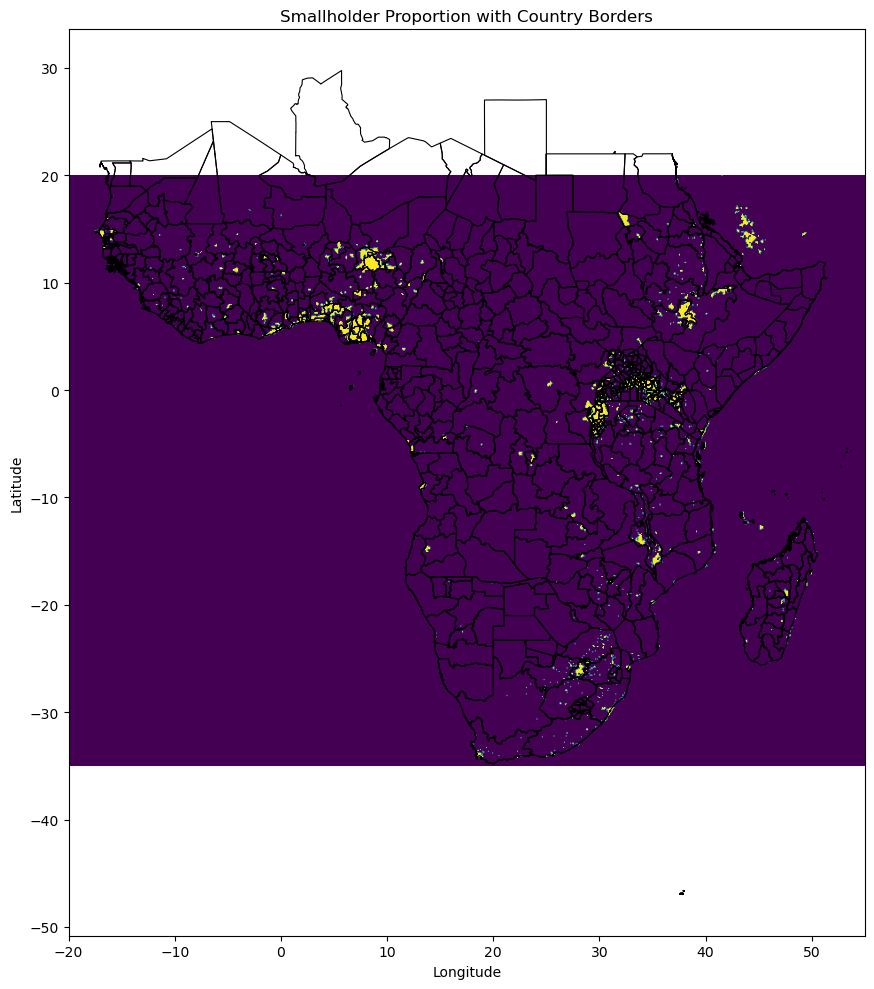

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import os 
# --- Configuration ---
# Path to the GeoTIFF you saved (e.g., the smallholder proportion band)
output_geotiff_path = r"../Data\2DSUM-Gridded\ssa_population_attribution_v2_urban_prop.tif" # ADJUST PATH

# Path to your downloaded border shapefile (e.g., Natural Earth countries)
borders_shapefile_path = r'''C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded\Borders-level1/gaul1_asap.shp''' # ADJUST PATH

# --- Load Data ---
try:
    # Load the raster data
    raster_data = rasterio.open(output_geotiff_path)

    # Load the border data
    borders = gpd.read_file(borders_shapefile_path)

    # Optional: Filter borders to roughly match your SSA extent for faster plotting
    # This uses the bounds from the raster, you could also use your ssa_bounds dict
    raster_bounds = raster_data.bounds
    borders_clipped = borders.cx[raster_bounds.left:raster_bounds.right,
                                 raster_bounds.bottom:raster_bounds.top]

    # Ensure borders are in the same CRS as the raster
    # If not, reproject borders. Example:
    if borders_clipped.crs != raster_data.crs:
         print(f"Reprojecting borders from {borders_clipped.crs} to {raster_data.crs}...")
         borders_clipped = borders_clipped.to_crs(raster_data.crs)

except FileNotFoundError as e:
    print(f"Error loading files: {e}. Ensure paths are correct.")
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    exit()


# --- Plotting ---
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the raster data (showing the first band)
# Adjust colormap (cmap) and normalization (vmin, vmax) as needed
show(raster_data, ax=ax, cmap='viridis', vmin=0, vmax=1) # Assuming proportions 0-1

# Plot the borders on top
borders_clipped.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8)

# Customize plot (optional)
ax.set_title("Smallholder Proportion with Country Borders")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# You might want to hide axes ticks/labels for a cleaner map
# ax.set_xticks([])
# ax.set_yticks([])

plt.tight_layout()
plt.show()

# Close the raster file
raster_data.close()

# Part 2: Compare district (admin-1) level food security statistics with corresponding estimates of employment type 



### Aggregate the population counts to adm1 level

In [124]:
import geopandas as gpd
import rasterio
import rasterstats # Use zonal_stats from here
import pandas as pd
import numpy as np
import os
import warnings

# --- Configuration ---

# !!! IMPORTANT: SET PATHS TO YOUR FILES HERE !!!
# Path to the ADM1 shapefile
adm1_shapefile_path =  r'''C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded\Boundaries_admin_level_1\afr_g2014_2013_1_update.shp''' # ADJUST PATH

# Folder where the output GeoTIFFs from the previous script were saved
geotiff_output_folder = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded" # <--- CHANGE THIS PATH (Must match previous script's output)

# --- Construct Paths to Input GeoTIFFs ---
# Uses the base name defined in the previous script (v4)
output_filename_base = "ssa_population_attribution_v4" # Make sure this matches the v4 script's output base name
# --- Path to the TOTAL POPULATION COUNT raster ---
pop_count_total_tif = os.path.join(geotiff_output_folder, f"{output_filename_base}_popcount_total.tif")
# --- Paths to the PER-CATEGORY POPULATION COUNT rasters ---
pop_count_urban_tif = os.path.join(geotiff_output_folder, f"{output_filename_base}_popcount_urban.tif")
pop_count_aglaborer_tif = os.path.join(geotiff_output_folder, f"{output_filename_base}_popcount_aglaborer.tif")
pop_count_smallholder_tif = os.path.join(geotiff_output_folder, f"{output_filename_base}_popcount_smallholder.tif")

# Check if input files exist
required_files = [adm1_shapefile_path, pop_count_total_tif, pop_count_urban_tif, pop_count_aglaborer_tif, pop_count_smallholder_tif]
for f_path in required_files:
    if not os.path.exists(f_path):
        raise FileNotFoundError(f"Required input file not found: {f_path}")

print("--- Loading Data ---")
# Load ADM1 boundaries
try:
    adm1_gdf = gpd.read_file(adm1_shapefile_path)
    print(f"Loaded ADM1 shapefile: {adm1_shapefile_path} with {len(adm1_gdf)} features.")
except Exception as e: print(f"Error loading shapefile {adm1_shapefile_path}: {e}"); raise

# --- Check and Align CRS ---
try:
    with rasterio.open(pop_count_total_tif) as src: # Get CRS/Transform from total pop count raster
        raster_crs = src.crs
        raster_transform = src.transform
    print(f"Raster CRS: {raster_crs}")
except Exception as e: print(f"Error reading raster CRS from {pop_count_total_tif}: {e}"); raise

if adm1_gdf.crs != raster_crs:
    print(f"Warning: ADM1 CRS ({adm1_gdf.crs}) differs from Raster CRS ({raster_crs}). Reprojecting ADM1 features...")
    try:
        adm1_gdf = adm1_gdf.to_crs(raster_crs)
        print("ADM1 CRS reprojected successfully.")
    except Exception as e: print(f"Error reprojecting ADM1 shapefile: {e}"); raise
else:
    print("ADM1 CRS matches Raster CRS.")

# --- Calculate Zonal Statistics by Summing Pre-Calculated Counts ---
print("\n--- Calculating Zonal Statistics (Summing Pre-Calculated Counts) ---")

# 1. Calculate Total Population per ADM1 Zone (Sum of total population counts)
print("Calculating total population per zone...")
try:
    total_pop_stats = rasterstats.zonal_stats(
        adm1_gdf,
        pop_count_total_tif, # *** Use TOTAL Population COUNT raster ***
        stats="sum",
        geojson_out=False,
        nodata=0,
        affine=raster_transform
    )
    total_pop_per_zone = [stat['sum'] if stat and 'sum' in stat else 0 for stat in total_pop_stats]
    adm1_gdf['total_pop_count'] = np.array(total_pop_per_zone, dtype=np.float64)
    print("   Done.")
except Exception as e: print(f"Error during total population zonal_stats: {e}"); raise

# 2. Calculate Population Count per Category per ADM1 Zone (Sum of category counts)
#    *** This is now much simpler: just sum the corresponding count raster ***
category_count_tifs = {
    'urban': pop_count_urban_tif,
    'ag_laborer': pop_count_aglaborer_tif,
    'smallholder': pop_count_smallholder_tif
}
category_pop_cols = {} # To store the resulting column names

for category, count_tif_path in category_count_tifs.items():
    print(f"Calculating {category} population count per zone...")
    col_name = f"{category}_pop_count"
    category_pop_cols[category] = col_name
    try:
        # No weighting needed here, just sum the counts directly
        cat_pop_stats = rasterstats.zonal_stats(
            adm1_gdf,
            count_tif_path,        # *** Use PER-CATEGORY Population COUNT raster ***
            stats="sum",
            geojson_out=False,
            nodata=0,              # Treat 0 count as nodata for sum
            affine=raster_transform
            # No weight_raster needed!
        )
        cat_pop_per_zone = [stat['sum'] if stat and 'sum' in stat else 0 for stat in cat_pop_stats]
        adm1_gdf[col_name] = np.array(cat_pop_per_zone, dtype=np.float64)
        print("   Done.")
    except Exception as e: print(f"Error during {category} population zonal_stats: {e}"); raise

# 3. Calculate Uncategorized Population Count per ADM1 Zone
print("Calculating uncategorized population count per zone...")
urban_pop_col = category_pop_cols['urban']
aglaborer_pop_col = category_pop_cols['ag_laborer']
smallholder_pop_col = category_pop_cols['smallholder']
categorized_pop_sum = np.nansum([adm1_gdf[urban_pop_col],adm1_gdf[aglaborer_pop_col],adm1_gdf[smallholder_pop_col]],axis=0)
adm1_gdf['uncategorized_pop_count'] = (adm1_gdf['total_pop_count'] - categorized_pop_sum).clip(lower=0)
print("   Done.")

# --- Calculate Proportions per ADM1 Zone (Based on Counts) ---
print("\n--- Calculating Proportions per Zone ---")
total_pop_safe = adm1_gdf['total_pop_count'].replace(0, np.nan) # Avoid division by zero

adm1_gdf['urban_prop'] = (adm1_gdf[urban_pop_col] / total_pop_safe * 100).fillna(0)
adm1_gdf['ag_laborer_prop'] = (adm1_gdf[aglaborer_pop_col] / total_pop_safe * 100).fillna(0)
adm1_gdf['smallholder_prop'] = (adm1_gdf[smallholder_pop_col] / total_pop_safe * 100).fillna(0)
adm1_gdf['uncategorized_prop'] = (adm1_gdf['uncategorized_pop_count'] / total_pop_safe * 100).fillna(0)

# --- Display Results ---
print("\n--- Aggregated Results by ADM1 Unit (Counts & Proportions) ---")
display_cols = []
if 'NAME_1' in adm1_gdf.columns: display_cols.append('NAME_1')
elif 'ADM1_NAME' in adm1_gdf.columns: display_cols.append('ADM1_NAME')
display_cols.extend([
    'total_pop_count',
    'urban_pop_count', 'ag_laborer_pop_count', 'smallholder_pop_count', 'uncategorized_pop_count',
    'urban_prop', 'ag_laborer_prop', 'smallholder_prop', 'uncategorized_prop'
])
display_cols = [col for col in display_cols if col in adm1_gdf.columns]

pd.options.display.float_format = '{:,.0f}'.format # Format counts as integers
print(adm1_gdf[display_cols].head().to_markdown(index=False))

# --- Optional: Save Results ---
# output_geojson_path = os.path.join(geotiff_output_folder, "adm1_population_counts_proportions_v3.geojson")
# try:
#     adm1_gdf.to_file(output_geojson_path, driver='GeoJSON')
#     print(f"\nResults saved to GeoJSON: {output_geojson_path}")
# except Exception as e: print(f"\nError saving results file: {e}")

print("\n--- Analysis Complete ---")


--- Loading Data ---
Loaded ADM1 shapefile: C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded\Boundaries_admin_level_1\afr_g2014_2013_1_update.shp with 922 features.
Raster CRS: EPSG:4326
ADM1 CRS matches Raster CRS.

--- Calculating Zonal Statistics (Summing Pre-Calculated Counts) ---
Calculating total population per zone...
   Done.
Calculating urban population count per zone...
   Done.
Calculating ag_laborer population count per zone...
   Done.
Calculating smallholder population count per zone...
   Done.
Calculating uncategorized population count per zone...
   Done.

--- Calculating Proportions per Zone ---

--- Aggregated Results by ADM1 Unit (Counts & Proportions) ---
| ADM1_NAME                         |   total_pop_count |   urban_pop_count |   ag_laborer_pop_count |   smallholder_pop_count |   uncategorized_pop_count |   urban_prop |   ag_laborer_prop |   smallholder_prop |   uncategorized_prop |
|:----------------------------------|------------------:|------

### Bring in Food security statistics, and compare the employment estimates with official observations

In [70]:
import json
fschars_path = '../Data/nowcasting_food_insecurity_data_and_code_rebuttal_2/fs_timeseries_stats/food_security_characteristics.json'

# Optional: Load the dictionary back from the file to verify
try:
    with open(fschars_path, 'r') as f:
                food_security_characteristics = json.load(f)
    print("\nDictionary loaded back from file")
except Exception as e:
     print(f"An error occurred while loading the dictionary back: {e}")


Dictionary loaded back from file


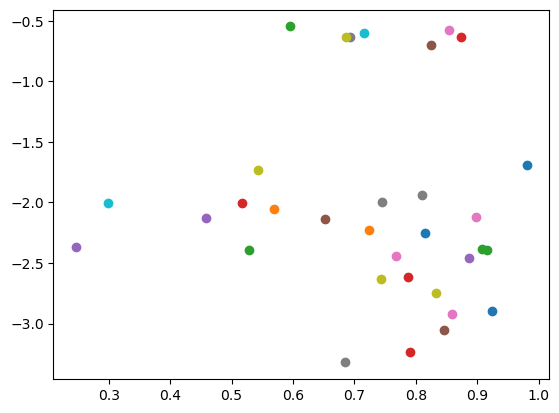

In [309]:
for Nation in adm1_gdf.ADM0_NAME.unique():
    if (Nation == "United Republic of Tanzania"):
        for District in  adm1_gdf[adm1_gdf["ADM0_NAME"]==Nation].ADM1_NAME.unique():
            try:
                employ_data = adm1_gdf[(adm1_gdf.ADM1_NAME==District) & (adm1_gdf.ADM0_NAME==Nation)]
                fs_data = food_security_characteristics[Nation][District]
                if True:#fs_data["mean"]<0.16900909057621868:#(fs_data["period"]<220) & (fs_data["period"]>140):
                    #plt.scatter(fs_data["mean"],np.log(fs_data["cv"]))
                    urban = employ_data.iloc[0].urban_pop_count
                    smallholder = employ_data.iloc[0].smallholder_pop_count
                    ag_laborer = employ_data.iloc[0].ag_laborer_pop_count
                    uncategorized = employ_data.iloc[0].uncategorized_pop_count
                    total = employ_data.iloc[0].total_pop_count
                    plt.scatter(smallholder/(smallholder+ag_laborer),np.log(np.clip(fs_data["mean"],0,1000)))
            except:
                #print(f"Missing data for {District} in {Nation}.")
                continue
        

In [ ]:
#
#Load obs. data on ag. employment 
#
#IFLP Substinence farmers data
observed_subsistence = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM-National\IFLP_SubsistenceFarmersbySex_2019-2024.csv")
# Mapping from observed_subsistence ref_area.label values to the ADM1 boundary names
country_mapping = {
    'Angola': 'Angola',
    "Côte d'Ivoire": "Cote d'Ivoire",
    'Comoros': 'Comoros',
    'Gambia': 'Gambia',
    'Liberia': 'Liberia',
    'Lesotho': 'Lesotho',
    'Madagascar': 'Madagascar',
    'Malawi': 'Malawi',
    'Rwanda': 'Rwanda',
    'Somalia': 'Somalia',
    'Eswatini': 'Swaziland',  # old name in your ADM1 file
    'Seychelles': 'Seychelles',
    'Tanzania, United Republic of': 'United Republic of Tanzania',
    'Uganda': 'Uganda',
    'Zambia': 'Zambia',
    'Zimbabwe': 'Zimbabwe'
}

# Example usage: add a column with the mapped ADM1 name
observed_subsistence['ADM1_NAME'] = observed_subsistence['ref_area.label'].map(country_mapping)
#FAO data
FAO_employment = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM-National\FAOSTAT_national-employmentsharesagriculture-2000-2021.csv")

array([1994, 2014, 2018, 2022, 2023, 2006], dtype=int64)

In [344]:
FAO_employment[(FAO_employment.Area=="Burkina Faso") & (FAO_employment.Year==2022)]

,Domain Code,Domain,Area Code (M49),Area,Indicator Code,Indicator,Sex Code,Sex,Year Code,Year,Element Code,Element,Source Code,Source,Unit,Value,Flag,Flag Description,Note
2830,OEA,Employment Indicators: Agriculture and agrifoo...,854,Burkina Faso,21155,Share of employment in agriculture in total em...,1,Total,2022,2022,6121,Value,3023,Labour force survey,%,31,X,Figure from international organizations,NaN
2833,OEA,Employment Indicators: Agriculture and agrifoo...,854,Burkina Faso,21155,Share of employment in agriculture in total em...,2,Male,2022,2022,6121,Value,3023,Labour force survey,%,34,X,Figure from international organizations,NaN
2836,OEA,Employment Indicators: Agriculture and agrifoo...,854,Burkina Faso,21155,Share of employment in agriculture in total em...,3,Female,2022,2022,6121,Value,3023,Labour force survey,%,29,X,Figure from international organizations,NaN


In [348]:
0.35 * 0.66

0.23099999999999998

In [341]:
FAO_employment[(FAO_employment.Area=="Senegal") & (FAO_employment.Year==2020)]

,Domain Code,Domain,Area Code (M49),Area,Indicator Code,Indicator,Sex Code,Sex,Year Code,Year,Element Code,Element,Source Code,Source,Unit,Value,Flag,Flag Description,Note
16481,OEA,Employment Indicators: Agriculture and agrifoo...,686,Senegal,21161,Share of AFS employment in total employment,1,Total,2020,2020,6121,Value,3044,FAO Model,%,35,E,Estimated value,Modelled FAO
16503,OEA,Employment Indicators: Agriculture and agrifoo...,686,Senegal,21162,Share of agricultural employment in total AFS ...,1,Total,2020,2020,6121,Value,3044,FAO Model,%,66,E,Estimated value,ILO Modelled Estimates
16525,OEA,Employment Indicators: Agriculture and agrifoo...,686,Senegal,21164,Share of non-agricultural AFS employment in to...,1,Total,2020,2020,6121,Value,3044,FAO Model,%,34,E,Estimated value,Modelled FAO


In [350]:
employ_data

,ADM1_CODE,ADM1_NAME,ADM0_CODE,ADM0_NAME,CONTINEN_1,REGION_1,geometry,total_pop_count,urban_pop_count,ag_laborer_pop_count,smallholder_pop_count,uncategorized_pop_count,urban_prop,ag_laborer_prop,smallholder_prop,uncategorized_prop
76,398,Bengo,8,Angola,Africa,Southern Africa,"POLYGON ((13.81713 -7.61965, 13.85907 -7.63049...","854,803","257,889","34,590","128,473","433,850",30,4,15,51
77,399,Benguela,8,Angola,Africa,Southern Africa,"MULTIPOLYGON (((12.52282 -13.4516, 12.52295 -1...","1,986,477",NaN,"86,700","529,032","1,370,744",0,4,27,69
78,400,Bie,8,Angola,Africa,Southern Africa,"POLYGON ((16.7749 -10.76632, 16.78463 -10.7707...","1,085,030",NaN,"17,864","374,964","692,201",0,2,35,64
79,401,Cabinda,8,Angola,Africa,Southern Africa,"POLYGON ((12.79604 -4.41363, 12.79972 -4.41889...","1,235,054",NaN,"234,428","1,000,627",0,0,19,81,0
80,402,Cuando Cubango,8,Angola,Africa,Southern Africa,"POLYGON ((18.15657 -13.67715, 18.18018 -13.692...","480,758",NaN,"2,681","42,976","435,101",0,1,9,91
81,403,Cuanza Sul,8,Angola,Africa,Southern Africa,"MULTIPOLYGON (((13.70935 -10.5887, 13.70934 -1...","1,898,778",NaN,"105,300","1,781,986","11,492",0,6,94,1
82,404,Cunene,8,Angola,Africa,Southern Africa,"POLYGON ((16.65574 -15.16243, 16.68185 -15.162...","1,287,946",NaN,"79,310","208,550","1,000,086",0,6,16,78
88,405,Huambo,8,Angola,Africa,Southern Africa,"POLYGON ((16.07935 -11.45688, 16.10074 -11.471...","1,671,639",NaN,"46,974","602,799","1,021,866",0,3,36,61
89,406,Huila,8,Angola,Africa,Southern Africa,"POLYGON ((16.28102 -13.35743, 16.30685 -13.370...","3,180,868",NaN,"18,361","519,152","2,643,355",0,1,16,83
90,407,Kuanza Norte,8,Angola,Africa,Southern Africa,"POLYGON ((15.4873 -8.05383, 15.49439 -8.05528,...","302,664",NaN,"13,359","289,304",0,0,4,96,0


In [349]:
#
#Check predicted ag. employment proportions against observed at national levels
#

for Nation in adm1_gdf.ADM0_NAME.unique():
    if Nation == "Angola":
        try:
            employ_data = adm1_gdf[adm1_gdf.ADM0_NAME==Nation]
            fs_data = food_security_characteristics[Nation]
            urban = np.nansum(employ_data.urban_pop_count)
            smallholder = np.nansum(employ_data.smallholder_pop_count)
            ag_laborer = np.nansum(employ_data.ag_laborer_pop_count)
            uncategorized = np.nansum(employ_data.uncategorized_pop_count)
            total = np.nansum(employ_data.total_pop_count)
            
            AFS_emp = FAO_employment[(FAO_employment.Area == Nation)&(FAO_employment.Indicator=="Share of AFS employment in total employment") & (FAO_employment["Year Code"] == 2020)].Value.values[0]
            farmer_emp = FAO_employment[(FAO_employment.Area == Nation)&(FAO_employment.Indicator=="Share of employment in agriculture in total employment") & (FAO_employment["Year Code"] == 2020)].Value.values[0]
            #obs_small = observed_subsistence[(observed_subsistence["ADM1_NAME"] == Nation)&(observed_subsistence["sex.label"]=="Total")].iloc[0].obs_value*1000
            if obs_small != 0:
                print(Nation)
                print((100*(smallholder+ag_laborer)/(total*0.9))/farmer_emp)
                #print(smallholder/obs_small)
        except:
            continue
            #print(f"Missing data for {Nation}.")
        continue

### Bring in monthly prices: beginning to focus on Tanzania due to relative accuracy of national level estimate

In [320]:
Tanzania_Market_Prices = pd.read_csv(r"../Data/2DSUM-Gridded/WFP-mVAM_RetailFoodPrices-Tanzania_2019-2025.csv")

In [330]:
Tanzania_Market_Prices[Tanzania_Market_Prices["Admin 2"].unique()

array(['Ngorongoro', 'Ilala', 'Temeke', 'Dodoma Urban', 'Mbogwe',
       'Iringa Rural', 'Muleba', 'Mlele', 'Kasulu', 'Mwanga', 'Liwale',
       'Simanjiro', 'Butiama', 'Chunya', 'Kilombero', 'Masasi',
       'Nyamagana', 'Njombe Urban', 'Kisarawe', 'Nkasi', 'Namtumbo',
       'Kahama', 'Meatu', 'Manyoni', 'Sikonge', 'Handeni'], dtype=object)

In [327]:
adm1_gdf[adm1_gdf["ADM0_NAME"]=="United Republic of Tanzania"].ADM1_NAME.unique()

array(['Arusha', 'Dar es salaam', 'Dodoma', 'Kigoma', 'Kilimanjaro',
       'Lindi', 'Manyara', 'Mara', 'Mbeya', 'Morogoro', 'Mtwara',
       'Kaskazini Pemba', 'Kaskazini Unguja', 'Pwani', 'Ruvuma',
       'Singida', 'Kusini Pemba', 'Kusini Unguja', 'Tabora', 'Tanga',
       'Mjini Magharibi', 'Geita', 'Iringa', 'Kagera', 'Katavi', 'Mwanza',
       'Njombe', 'Rukwa', 'Shinyanga', 'Simiyu'], dtype=object)